<a href="https://colab.research.google.com/github/saniya1027108/Research---Knowledge-Distillation-/blob/main/KD_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [ ]:
import numpy as np
import tensorflow as tf

# Prepare the train and test dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Add channel dimension for grayscale images
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

print("Input Train data  ", x_train.shape)
print("Train data Labels ", y_train.shape)
print("Input Test data   ", x_test.shape)
print("Test data Labels  ", y_test.shape)


Input Train data   (60000, 28, 28, 1)
Train data Labels  (60000,)
Input Test data    (10000, 28, 28, 1)
Test data Labels   (10000,)


In [ ]:
teacher = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),

        tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
        tf.keras.layers.Conv2D(512, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10),
    ],
    name="teacher",
)
teacher.summary()


Model: "teacher"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 256)       2560      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 14, 14, 256)       0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 256)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 14, 14, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 512)         1180160   
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 7, 7, 512)         0         
                                                           

In [ ]:
# Create the student
student = tf.keras.Sequential(
    [
        tf.keras.Input(shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
        tf.keras.layers.Conv2D(256, (3, 3), strides=(2, 2), padding="same"),
        tf.keras.layers.LeakyReLU(alpha=0.2),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
        tf.keras.layers.Dropout(0.5),  # Dropout layer for regularization
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10),
    ],
    name="student",
)
student.summary()


Model: "student"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 14, 14, 64)        640       
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 14, 14, 64)        0         
 g2D)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_3 (Conv2D)           (None, 7, 7, 256)         147712    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 7, 7, 256)         0         
                                                           

In [ ]:
teacher.compile(
    optimizer=tf.keras.optimizers.Adam(),    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
# Train and evaluate teacher on data.
history_teacher = teacher.fit(x_train, y_train, epochs=5)
teacher.evaluate(x_test, y_test)

Epoch 1/5
1875/1875 [==============================] - 26s 10ms/step - loss: 0.4469 - sparse_categorical_accuracy: 0.8408
Epoch 2/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3563 - sparse_categorical_accuracy: 0.8741
Epoch 3/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3396 - sparse_categorical_accuracy: 0.8800
Epoch 4/5
1875/1875 [==============================] - 15s 8ms/step - loss: 0.3341 - sparse_categorical_accuracy: 0.8820
Epoch 5/5
313/313 [==============================] - 1s 4ms/step - loss: 0.3351 - sparse_categorical_accuracy: 0.8821


[0.33513274788856506, 0.882099986076355]

In [ ]:
class Distiller(keras.Model):
    def __init__(self, student, teacher):
        super(Distiller, self).__init__()
        self.teacher = teacher
        self.student = student

    def compile(
        self,
        optimizer,
        metrics,
        student_loss_fn,
        distillation_loss_fn,
        alpha=0.1,
        temperature=3,
    ):

        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics)
        self.student_loss_fn=student_loss_fn
        self.distillation_loss_fn= distillation_loss_fn
        self.temperature= temperature
        self.alpha= alpha

    def train_step(self, data):
        x,y=data

        # Forward pass of teacher
        teacher_prediction=self.teacher(x, training=False)
        print("Tecaher prediction   ...", teacher_prediction)
        with tf.GradientTape() as tape:
            # Forward pass of student
            student_predcition= self.student(x, training=True)
            # Compute losses
            student_loss= self.student_loss_fn(y, student_predcition)

            distillation_loss=self.distillation_loss_fn(
            tf.nn.softmax(teacher_prediction/self.temperature, axis=1),
            tf.nn.softmax(student_predcition/self.temperature, axis=1)
            )
            loss= self.alpha* student_loss + (1-self.alpha)* distillation_loss
            print("Loss in distiller :",loss)
            # Compute gradients
            trainable_vars= self.student.trainable_variables
            gradients=tape.gradient(loss, trainable_vars)
            gradients = [gradient * (self.temperature ** 2) for gradient in gradients]
            # Update weights
            self.optimizer.apply_gradients(zip(gradients, trainable_vars))

            # Update the metrics configured in `compile()`
            self.compiled_metrics.update_state(y, student_predcition)

            # Return a dict of performance
            results={ m.name: m.result()  for m in self.metrics}
            results.update({"student_loss": student_loss, "distillation_loss": distillation_loss})
            print("Train...", results)
            return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        ## Compute predictions
        y_prediction= self.student(x, training=False)

        # calculate the loss
        student_loss= self.student_loss_fn(y, y_prediction)

        # Update the metrics.
        self.compiled_metrics.update_state(y, y_prediction)

        # Return a dict of performance
        results ={m.name: m.result() for m in self.metrics}
        results.update({"student_loss": student_loss})
        print("Test...", results)
        return results
# Initialize  distiller
distiller= Distiller(student=student, teacher=teacher)

In [ ]:
#compile distiller
distiller.compile(optimizer=keras.optimizers.Adam(),
                 metrics=[keras.metrics.SparseCategoricalAccuracy()],
                 student_loss_fn=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 distillation_loss_fn=keras.losses.KLDivergence(),
                 alpha=0.3,
                 temperature=7)

In [ ]:
# Distill teacher to student
history_student = distiller.fit(x_train, y_train, epochs=5)
# Evaluate student on test dataset
distiller.evaluate(x_test, y_test)

Epoch 1/5
Tecaher prediction   ... Tensor("teacher/dense/BiasAdd:0", shape=(32, 10), dtype=float32)
Loss in distiller : Tensor("add:0", shape=(), dtype=float32)
Train... {'sparse_categorical_accuracy': <tf.Tensor 'Identity_6:0' shape=() dtype=float32>, 'student_loss': <tf.Tensor 'sparse_categorical_crossentropy/weighted_loss/value:0' shape=() dtype=float32>, 'distillation_loss': <tf.Tensor 'kl_divergence/weighted_loss/value:0' shape=() dtype=float32>}
Tecaher prediction   ... Tensor("teacher/dense/BiasAdd:0", shape=(32, 10), dtype=float32)
Loss in distiller : Tensor("add:0", shape=(), dtype=float32)
Train... {'sparse_categorical_accuracy': <tf.Tensor 'Identity_6:0' shape=() dtype=float32>, 'student_loss': <tf.Tensor 'sparse_categorical_crossentropy/weighted_loss/value:0' shape=() dtype=float32>, 'distillation_loss': <tf.Tensor 'kl_divergence/weighted_loss/value:0' shape=() dtype=float32>}
1875/1875 [==============================] - 14s 5ms/step - sparse_categorical_accuracy: 0.8268 - 

[0.885699987411499, 0.2039467692375183]

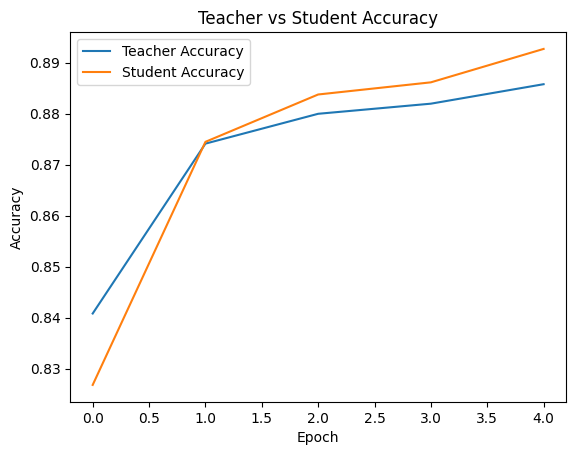

In [ ]:
# Plot accuracy for teacher and student models
import matplotlib.pyplot as plt

plt.plot(history_teacher.history['sparse_categorical_accuracy'], label='Teacher Accuracy')
plt.plot(history_student.history['sparse_categorical_accuracy'], label='Student Accuracy')
plt.title('Teacher vs Student Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
#plt.ylim((80, 95))  # Set a fixed y-axis range for consistency
#plt.yticks(np.arange(80, 96, 2))
plt.legend()
plt.show()